1
ref  human  to target(s)  ['human', 'mouse']
0.89 0.89
Sens. at 90% spec 0.78
1
ref  mouse  to target(s)  ['human', 'mouse']
0.9 0.9
Sens. at 90% spec 0.76
11
ref  human  to target(s)  {'rhesus', 'cow', 'cat', 'chicken', 'opossum', 'horse', 'lizard', 'dog', 'sheep', 'rat', 'pig', 'frog', 'rabbit'}
0.81 0.87
Sens. at 90% spec 0.67
7
ref  mouse  to target(s)  {'rhesus', 'cow', 'cat', 'chicken', 'opossum', 'horse', 'lizard', 'dog', 'sheep', 'rat', 'pig', 'frog', 'rabbit'}
0.83 0.89
Sens. at 90% spec 0.73
ROC panel performance plot created


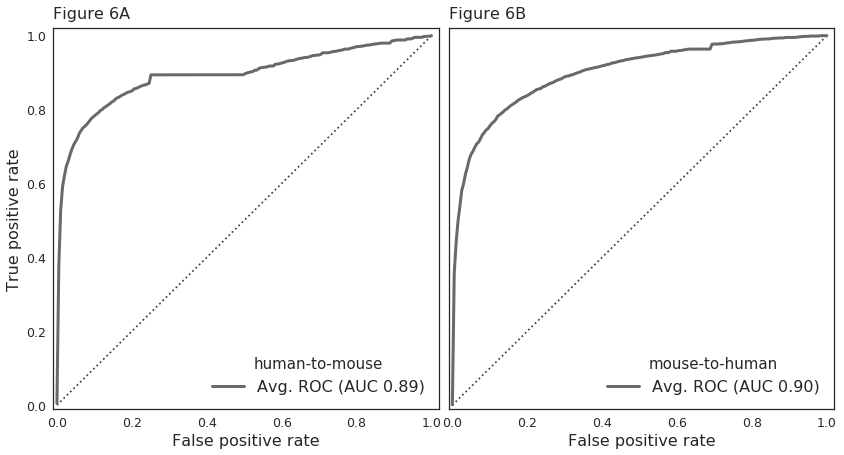

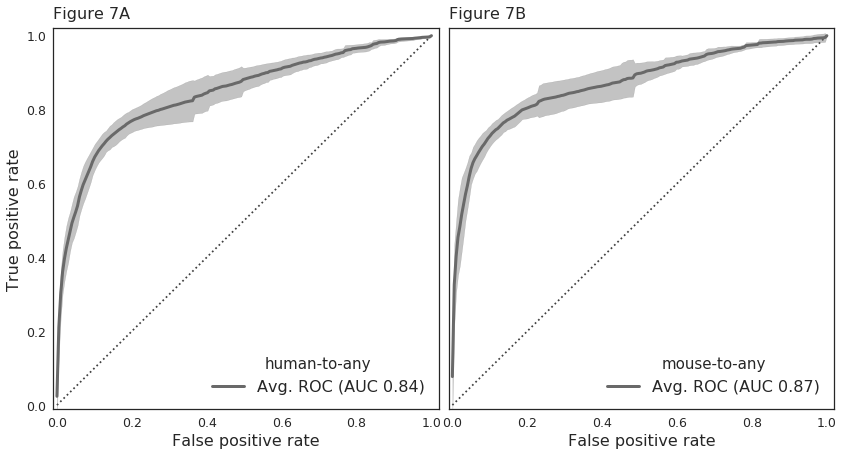

In [1]:
%matplotlib inline

import os as os
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle
from sklearn.metrics import auc, roc_auc_score, \
    average_precision_score, precision_recall_curve, roc_curve

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import numpy as np
import numpy.random as rng
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

from sklearn.metrics import precision_recall_fscore_support as pfm

# What is this?
# Plot combined ROC (human and mouse)
# for the generic tissue type "any" setting
# These plots do not include a control curve,
# just the main diagonal of the coin flip model

date = '20180425'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

run_exec_perf_roc_joint = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True


def exec_status():
    cache_file = os.path.join(cache_dir, '{}_plot_perfcomp_roc-joint.h5'.format(date))
    model = 'can'
    test = 'avg'
    control = 'ctl'
    # return collect_perf, t_interp, control_auc
    if os.path.isfile(cache_file):
        perf_scores = cache_data(cache_file, None, None, None)
    else:
        raw_perf, fpr, collect_aucs = collect_roc_curves(stat_file, model, test, control)
        perf_scores = cache_data(cache_file, raw_perf, fpr, collect_aucs)
    fig, exart = plot_roc_joint(perf_scores,
                                ['human', 'mouse'],
                                ['human', 'mouse'],
                                ['human-to-mouse', 'mouse-to-human'],
                                ['6A', '6B'])
    if save_figures:
        outname = 'fig_6AB_roc-hm_perf'
        outpath = os.path.join(out_folder, 'main', 'raw', outname + '.svg')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        
        outpath = os.path.join(out_folder, 'main', 'png', outname + '.png')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        
        outpath = os.path.join(out_folder, 'main', outname + '.pdf')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        
    species, lca = read_references(species_file, lca_times_file)
    
    trg_species = set(list(species.keys())) - set(['human', 'mouse'])
    
    fig, exart = plot_roc_joint(perf_scores,
                                ['human', 'mouse'],
                                trg_species,
                                ['human-to-any', 'mouse-to-any'],
                                ['7A', '7B'])
    if save_figures:
        outname = 'fig_7AB_roc-all_perf'
        outpath = os.path.join(out_folder, 'main', 'raw', outname + '.svg')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        
        outpath = os.path.join(out_folder, 'main', 'png', outname + '.png')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        
        outpath = os.path.join(out_folder, 'main', outname + '.pdf')
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    
    return True


def cache_data(cache_file, perfs, fprs, collect_aucs):
    
    if os.path.isfile(cache_file):
        perf_scores = {}
        with pd.HDFStore(cache_file, 'r') as hdf:
            for k in hdf.keys():
                if k.startswith('/collect_auc') or k.startswith('/fpr'):
                    continue
                _, ref, trg, comp, data = k.split('/')
                dataset = hdf[k]
                perf_scores[(ref, trg, comp, data)] = dataset
            perf_scores[(None, None, None, 'fpr')] = hdf['fpr']
        return perf_scores
    else:
        with pd.HDFStore(cache_file, 'w') as hdf:
            hdf.put('/collect_auc', collect_aucs, format='table')
            for (ref, trg, comp, data), obj in perfs.items():
                if data == 'auc':
                    hdf.put(os.path.join(ref, trg, comp, data), pd.Series(obj), format='fixed')
                elif data == 'tpr':
                    df = pd.DataFrame(obj, index=np.arange(len(obj)),
                                      columns=np.arange(obj[0].size))
                    hdf.put(os.path.join(ref, trg, comp, data), df, format='fixed')
                else:
                    raise ValueError('Unexpected data type: {}'.format(data))
            hdf.put('/fpr', pd.Series(fprs), format='fixed')
            hdf.flush()
        return cache_data(cache_file, None, None, None)


def merge_tpr_curves(perf_data, ref, trg, comparison):
    
    collector = []
    for (r, t, c, d), values in perf_data.items():
        if d == 'tpr' and c == comparison:
            if r == ref and (t == trg or trg == 'all' or t in trg):
                collector.append(values)
    collector = pd.concat(collector, axis=0, ignore_index=False)
    return collector


def extract_auc_values(perf_data, ref, trg, comparison):
    
    collector = []
    for (r, t, c, d), values in perf_data.items():
        if d == 'auc' and c == comparison:
            if r == ref and (t == trg or trg == 'all' or t in trg):
                collector.extend(values)
    return np.array(collector, dtype=np.float64).round(2)
    
    
def plot_roc_joint(perf_data, ref_spec, trg_spec, labels, fkeys):
    """
    """
    num_cols = 2
    num_rows = 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 7),
                             sharex=False, sharey=True)
    extra_artists = []
    
    x_vals_fpr = perf_data[(None, None, None, 'fpr')]
    for ref, lab, fk, ax in zip(ref_spec, labels, fkeys, axes):
        ax.set_xlim(-0.01, 1.02)
        ax.set_ylim(-0.01, 1.02)
        ax.set_xlabel('False positive rate', fontsize=16)
        if 'A' in fk:
            ax.set_ylabel('True positive rate', fontsize=16)
        at = ax.set_title('Figure {}'.format(fk), fontsize=16)
        at.set_position([0.1, 1.01])
        
        tpr = merge_tpr_curves(perf_data, ref, trg_spec, 'avg')
        tpr_mean = tpr.mean(axis=0)
        tpr_std = tpr.std(axis=0)
        
        auc_all = extract_auc_values(perf_data, ref, trg_spec, 'avg')
        
        ### Values for publication
        print(auc_all.size)
        print('ref ', ref, ' to target(s) ', trg_spec)
        print(auc_all.min(), auc_all.max())
        print('Sens. at 90% spec', tpr_mean[20].round(2))
        ###
        mean_auc = auc(x_vals_fpr, tpr_mean, reorder=True).round(2)
    
        
        # plot test perf
        ax.plot(x_vals_fpr, tpr_mean, color='dimgrey',
                ls='solid', lw=3, zorder=3,
                label='Avg. ROC (AUC {:.2f})'.format(mean_auc))

        ax.fill_between(x_vals_fpr,
                        tpr_mean - tpr_std,
                        tpr_mean + tpr_std,
                        alpha=0.4, color='dimgrey', zorder=2)
        
        ax.plot((0, 1), (0, 1), ls='dotted', color='black',
                alpha=0.75, zorder=1)
        ax.legend(loc='lower right', ncol=1, title=lab, fontsize=16)
        
    plt.subplots_adjust(wspace=0.025)
    
    return fig, extra_artists


def read_references(species, lca):
    """
    """
    lca_dist = dict()
    with open(lca_times_file, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            if r['timetree-org'] in ['human', 'mouse']:
                src = r['timetree-org']
                for k, v in r.items():
                    if k.startswith('time'):
                        continue
                    lca_dist[(src, k)] = int(v)
            else:
                break
    
    spec_ann = dict()
    with open(species, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            spec_ann[r['common_name']] = r

    return spec_ann, lca_dist
  

def collect_roc_curves(model_file, model_type, test_comp, control_comp):
    print('collecting')
    # interpolation points to
    # merge all ROC curves
    t_interp = np.linspace(0, 1, num=200, endpoint=True).round(3)
    collect_perf = col.defaultdict(list)
    collect_aucs = []
    with pd.HDFStore(model_file, 'r') as model_hdf:
        all_keys = list(model_hdf.keys())
        filter_1 = '/{}/{}'.format(control_comp, model_type)
        filter_2 = '/{}/{}'.format(test_comp, model_type)
        model_keys = sorted([k for k in all_keys if (k.startswith(filter_1) or k.startswith(filter_2))
                             and k.endswith('/roc')])
        for mk in model_keys:
            # after update, add check here for perm test scores
            components = mk.split('/')
            _, comp, featset, ref, trg, model, data, _ = components
            
            roc_data = model_hdf[mk]
            perf_data = model_hdf[mk.replace('/roc', '/perf')]
            
            auc = perf_data.loc['perf_wg', 'auc_roc']
            x_fpr = roc_data.loc['fpr', :].values
            y_tpr = roc_data.loc['tpr', :].values
            
            model_epi, model_exp, _, _ = model.split('_')
            test_epi, test_exp, _, _ = data.split('_')
            
            collect_aucs.append((ref, trg, model_epi, model_exp, test_epi, test_exp, auc))
            
            new_y_tpr = np.interp(t_interp, x_fpr, y_tpr)
                        
            collect_perf[(ref, trg, comp, 'tpr')].append(new_y_tpr)
            collect_perf[(ref, trg, comp, 'auc')].append(auc)
    
    collect_aucs = pd.DataFrame(collect_aucs, index=np.arange(len(collect_aucs)),
                               columns=['reference', 'target', 'model_epi', 'model_exp',
                                        'test_epi', 'test_exp', 'auc'])
    
    return collect_perf, t_interp, collect_aucs


if run_exec_perf_roc_joint:
    execd = exec_status()
    print('ROC panel performance plot created')
